In [1]:
from ptycho.multires.class_multiressolver import *
import matplotlib.pyplot as plt
import torch.nn.functional as func
import torch
from ptycho.tools.ptychography import Ptychography2_v2 as Ptychography2
np.random.seed(0)
torch.manual_seed(0)


/home/efe/Desktop/Multiresolution-Framework-for-Fourier-Ptychography/.venv/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
def extract_data(nested_list):
    result = []
    for item in nested_list:
        if isinstance(item, list):  # If the item is a list, recurse into it
            result.extend(extract_data(item))
        else:  # If the item is not a list, add it to the result
            result.append(item)
    return result


def unwrap_2d(phase):
    """
    Unwraps a 2D phase array using NumPy's 1D unwrap function.
    
    Parameters:
    phase (numpy array): The 2D phase array to be unwrapped.
    
    Returns:
    unwrapped_phase (numpy array): The 2D unwrapped phase array.
    """
    # Unwrap along the first axis (rows)
    unwrapped_phase = np.unwrap(phase, axis=0)
    
    # Unwrap along the second axis (columns)
    unwrapped_phase = np.unwrap(unwrapped_phase, axis=1)
    
    return unwrapped_phase

def plot_results(model,image):
    plt.figure(figsize=(55, 10),dpi = 600)    

    plt.subplot(1, 5, 1)
    plt.imshow(image,cmap='gray')
    plt.title("Original Image")
    plt.colorbar()


    plt.subplot(1, 5, 2)
    phase = torch.angle(model.sols[-1][0,0,:,:].to('cpu'))
    phase = unwrap_2d(phase)
    plt.imshow(phase,cmap = 'gray')
    plt.title("Reconstructed Image")
    plt.colorbar()


    plt.subplot(1, 5, 3)
    plt.imshow(np.abs(np.array(image)-np.array(phase)),cmap='gray')
    plt.title("Loss")
    plt.colorbar()

    # plt.subplot(1, 5, 4)
    # plt.title("Log(Loss) vs Iterations")
    # plt.plot(np.log10(extract_data(model.measures["loss"])),label = "Loss",color = 'blue')

    # plt.subplot(1, 5, 5)
    # plt.title("LR vs Iterations")
    # plt.plot(model.lr_list,label = "LR",color = 'red')


    return None 


In [3]:
def run_test(lmbd):
    # Setting the operating device as cpu and the inital as ...
    
    scale = 7
    I_in = 15*np.array([1, 15, 10, 5, 2, 5, 10, 30, 100])
    I_out = 24*np.array([0, 0, 0, 0, 8, 7, 6, 5, 80])
    #I_out = 300*np.array([0, 0, 0, 0, 0, 0, 0, 0, 10])
    cycle = [0, -1, -1, -1, -1,1,  1, 1, 1]
    device = "cuda"
    lmbda = lmbd
    LR = 1e-2
    tol = [1e-10] * 9
    tol_in = [1e-10] * 9
    img_count = 10*10

    linOperator = Ptychography2(in_shape=(2**scale-1, 2**scale-1), n_img=img_count, probe_type='square',
                           probe_radius=32, defocus_factor=0, 
                           fov=170, threshold=0.3, device=device)

    image = plt.imread('images/peppers_reduced.jpg')[:2**scale-1, :2**scale-1] / 255
    image_tensor = torch.tensor(image).double().to(device).view(1, 1, 2**scale-1, 2**scale-1)
    image_tensor_ = torch.exp(1j * image_tensor)
    #image_tensor_ = torch.stack([image_tensor, image_tensor], dim=-1)
    #image_tensor_ = torch.view_as_complex(image_tensor_).to(torch.complex64)
    
    #Initiate the MultiRes class with the inital scale.
    multires = MultiRes(scale, device)
    loss = Loss(linOperator,linOperator.apply(image_tensor_), lmbda = lmbda)

    model = MultiResSolver(multires, loss, LR = LR,
                           I_in = I_in,
                           I_out = I_out,
                           tol = tol,
                           tol_in = tol_in,
                           cycle = cycle,
                           l1_type = "l1_row")
    
    model.solve_multigrid()
    model.print_time()
    return model

In [ ]:
image = plt.imread('images/peppers_reduced.jpg')[:2**7-1, :2**7-1] / 255
model7 = run_test(lmbd = 1e-7)
model6 = run_test(lmbd = 1e-6)
model5 = run_test(lmbd = 1e-5)
model4 = run_test(lmbd = 1e-4)
model3 = run_test(lmbd = 1e-3)

# %%

In [5]:
def plot_results(model,image):
    plt.figure(figsize=(18, 5),dpi = 200)    

    plt.subplot(1, 3, 1)
    plt.imshow(image,cmap='gray')
    plt.title(r"$(a)$ Phase of GT $(\angle x)$")
    plt.colorbar()


    plt.subplot(1, 3, 2)
    phase = torch.angle(model.sols[-1][0,0,:,:].to('cpu'))
    phase = unwrap_2d(phase)
    phase = (phase - np.min(phase))/(np.max(phase) - np.min(phase))
    plt.imshow(phase,cmap = 'gray')
    plt.title(r"(b) Phase of Reconstruction $(\angle \hat{x})$")
    plt.colorbar()


    plt.subplot(1, 3, 3)
    plt.imshow(np.abs(np.array(image)-np.array(phase))**2,cmap='gray')
    plt.title(r"(c) MSE: $(||\angle x- \angle \hat{x}||^2)$") 
    plt.colorbar()
    plt.tight_layout()
    plt.savefig('n_figs/nonlinear_old.png')
    plt.savefig('n_figs/nonlinear_old.eps')

    return None 


In [ ]:
plt.figure(figsize=(12, 4),dpi = 200)
plt.semilogy(extract_data(model3.measures["loss"]),label = r"Loss @ $\lambda = 10^{-3}$",color = 'blue')
plt.semilogy(extract_data(model4.measures["loss"]),label = r"Loss @ $\lambda = 10^{-4}$",color = 'red')
plt.semilogy(extract_data(model5.measures["loss"]),label = r"Loss @ $\lambda = 10^{-5}$",color = 'purple')
plt.semilogy(extract_data(model6.measures["loss"]),label = r"Loss @ $\lambda = 10^{-6}$",color = 'black')
plt.semilogy(extract_data(model7.measures["loss"]),label = r"Loss @ $\lambda = 10^{-7}$",color = 'orange')
plt.legend()
plt.grid()
plt.xlabel("Iterations")
plt.ylabel(r"$Log(|A\hat{x}-y|^2)$")
plt.tight_layout()
plt.savefig('n_figs/nonlinear_old_lambda.png')
plt.savefig('n_figs/nonlinear_old_lambda.eps')

In [ ]:
plt.figure(figsize=(12, 4),dpi = 200)
plt.plot(model3.lr_list,label = r"step size @ $\lambda = 10^{-3}$",color = 'blue')
plt.plot(model4.lr_list,label = r"step size @ $\lambda = 10^{-4}$" ,color = 'red')
plt.plot(model5.lr_list,label = r"step size @ $\lambda = 10^{-5}$",color = 'purple')
plt.plot(model6.lr_list,label = r"step size @ $\lambda = 10^{-6}$",color = 'black')
plt.plot(model7.lr_list,label = r"step size @ $\lambda = 10^{-7}$",color = 'orange')
plt.legend()
plt.xlabel("Iterations")
plt.ylabel(r"Step Size")
plt.grid()
plt.tight_layout()
plt.savefig('n_figs/nonlinear_old_lambda_lr.png')
plt.savefig('n_figs/nonlinear_old_lambda_lr.eps')

In [ ]:
plt.figure(figsize=(15, 18),dpi = 120)
plt.subplot(5, 3, 1)
plt.imshow(image,cmap='gray')
plt.title(r"$(1.a)$ Phase of GT $(\angle x)$ @ $\lambda = 10^{-7}$")
plt.colorbar()
plt.subplot(5, 3, 2)
phase = torch.angle(model7.sols[-1][0,0,:,:].to('cpu'))
phase = unwrap_2d(phase)
phase = (phase - np.min(phase))/(np.max(phase) - np.min(phase))
plt.imshow(phase,cmap = 'gray')
plt.title(r"$(1.b)$ Phase of Reconstruction $(\angle \hat{x})$ @ $\lambda = 10^{-7}$")
plt.colorbar()
plt.subplot(5, 3, 3)
plt.imshow((np.array(image)-np.array(phase))**2,cmap='gray')
plt.title(r"$(1.c)$ MSE: $(||\angle x-\angle \hat{x}||^2)$ @ $\lambda = 10^{-7}$") 
plt.colorbar()


plt.subplot(5, 3, 4)
plt.imshow(image,cmap='gray')
plt.title(r"$(2.a)$ Phase of GT $(\angle x)$ @ $\lambda = 10^{-6}$")
plt.colorbar()
plt.subplot(5, 3, 5)
phase = torch.angle(model6.sols[-1][0,0,:,:].to('cpu'))
phase = unwrap_2d(phase)
phase = (phase - np.min(phase))/(np.max(phase) - np.min(phase))
plt.imshow(phase,cmap = 'gray')
plt.title(r"$(2.b)$ Phase of Reconstruction $(\angle \hat{x})$ @ $\lambda = 10^{-6}$")
plt.colorbar()
plt.subplot(5, 3, 6)
plt.imshow(np.abs(np.array(image)-np.array(phase))**2,cmap='gray')
plt.title(r"$(2.c)$ MSE: $(||\angle x-\angle \hat{x}||^2)$ @ $\lambda = 10^{-6}$") 
plt.colorbar()

plt.subplot(5, 3, 7)
plt.imshow(image,cmap='gray')
plt.title(r"$(3.a)$ Phase of GT $(\angle x)$ @ $\lambda = 10^{-5}$")
plt.colorbar()
plt.subplot(5, 3, 8)
phase = torch.angle(model5.sols[-1][0,0,:,:].to('cpu'))
phase = unwrap_2d(phase)
phase = (phase - np.min(phase))/(np.max(phase) - np.min(phase))
plt.imshow(phase,cmap = 'gray')
plt.title(r"$(3.b)$ Phase of Reconstruction $(\angle \hat{x})$ @ $\lambda = 10^{-5}$")
plt.colorbar()
plt.subplot(5, 3, 9)
plt.imshow(np.abs(np.array(image)-np.array(phase))**2,cmap='gray')
plt.title(r"$(3.c)$ MSE: $(||\angle x-\angle \hat{x}||^2)$ @ $\lambda = 10^{-5}$") 
plt.colorbar()

plt.subplot(5, 3, 10)
plt.imshow(image,cmap='gray')
plt.title(r"$(4.a)$ Phase of GT $(\angle x)$ @ $\lambda = 10^{-4}$")
plt.colorbar()
plt.subplot(5, 3, 11)
phase = torch.angle(model4.sols[-1][0,0,:,:].to('cpu'))
phase = unwrap_2d(phase)
phase = (phase - np.min(phase))/(np.max(phase) - np.min(phase))
plt.imshow(phase,cmap = 'gray')
plt.title(r"$(4.b)$ Phase of Reconstruction $(\angle \hat{x})$ @ $\lambda = 10^{-4}$")
plt.colorbar()
plt.subplot(5, 3, 12)
plt.imshow(np.abs(np.array(image)-np.array(phase))**2,cmap='gray')
plt.title(r"$(4.c)$ MSE: $(||\angle x-\angle \hat{x}||^2)$ @ $\lambda = 10^{-4}$") 
plt.colorbar()

plt.subplot(5, 3, 13)
plt.imshow(image,cmap='gray')
plt.title(r"$(5.a)$ Phase of GT $(\angle x)$ @ $\lambda = 10^{-3}$")
plt.colorbar()
plt.subplot(5, 3, 14)
phase = torch.angle(model3.sols[-1][0,0,:,:].to('cpu'))
phase = unwrap_2d(phase)
phase = (phase - np.min(phase))/(np.max(phase) - np.min(phase))
plt.imshow(phase,cmap = 'gray')
plt.title(r"$(5.b)$ Phase of Reconstruction $(\angle \hat{x})$ @ $\lambda = 10^{-3}$")
plt.colorbar()
plt.subplot(5, 3, 15)
plt.imshow(np.abs(np.array(image)-np.array(phase))**2,cmap='gray')
plt.title(r"$(5.c)$ MSE: $(||\angle x-\angle \hat{x}||^2)$ @ $\lambda = 10^{-3}$") 
plt.colorbar()
plt.tight_layout()
plt.savefig('n_figs/nonlinear_old_lambda_images.png')
plt.savefig('n_figs/nonlinear_old_lambda_images.eps')

In [ ]:
model = run_test(lmbd = 1e-8)
plot_results(model,image)

In [1]:
def run_test(lmbd):
    # Setting the operating device as cpu and the inital as ...
    
    scale = 7
    I_in = 15*np.array([1, 15, 10, 5, 2, 5, 10, 30, 100])
    I_out = 40*np.array([0, 0, 0, 0, 20, 5, 5, 10, 70])
    #I_out = 300*np.array([0, 0, 0, 0, 0, 0, 0, 0, 10])
    cycle = [0, -1, -1, -1, -1,1,  1, 1, 1]
    device = "cuda"
    lmbda = lmbd
    LR = 1e-2
    tol = [1e-10] * 9
    tol_in = [1e-10] * 9
    img_count = 10*10

    linOperator = Ptychography2(in_shape=(2**scale-1, 2**scale-1), n_img=img_count, probe_type='square',
                           probe_radius=32, defocus_factor=0, 
                           fov=170, threshold=0.3, device=device)

    image = plt.imread('images/peppers_reduced.jpg')[:2**scale-1, :2**scale-1] / 255
    image_tensor = torch.tensor(image).double().to(device).view(1, 1, 2**scale-1, 2**scale-1)
    image_tensor_ = torch.exp(1j * image_tensor)
    
    #Initiate the MultiRes class with the inital scale.
    multires = MultiRes(scale, device)
    loss = Loss(linOperator,linOperator.apply(image_tensor_), lmbda = lmbda)

    model = MultiResSolver(multires, loss, LR = LR,
                           I_in = I_in,
                           I_out = I_out,
                           tol = tol,
                           tol_in = tol_in,
                           cycle = cycle,
                           l1_type = "l1_row")
    
    model.solve_multigrid()
    model.print_time()
    return model

In [ ]:
model1 = run_test(lmbd = 1e-7)

In [23]:
def run_test(lmbd,noise_std):
    # Setting the operating device as cpu and the inital as ...
    
    scale = 7
    I_in = 15*np.array([1, 15, 10, 5, 2, 5, 10, 30, 100])
    I_out = 24*np.array([0, 0, 0, 0, 8, 7, 6, 5, 60])
    #I_out = 300*np.array([0, 0, 0, 0, 0, 0, 0, 0, 10])
    cycle = [0, -1, -1, -1, -1,1,  1, 1, 1]
    device = "cuda"
    lmbda = lmbd
    LR = 1e-3
    tol = [1e-10] * 9
    tol_in = [1e-10] * 9
    img_count = 10*10

    linOperator = Ptychography2(in_shape=(2**scale-1, 2**scale-1), n_img=img_count, probe_type='square',
                           probe_radius=32, defocus_factor=0, 
                           fov=170, threshold=0.3, device=device)

    image = plt.imread('images/peppers_reduced.jpg')[:2**scale-1, :2**scale-1] / 255
    image_tensor = torch.tensor(image).double().to(device).view(1, 1, 2**scale-1, 2**scale-1)
    image_tensor_ = torch.exp(1j * (image_tensor))
    y = linOperator.apply(image_tensor_)
    y = y + torch.abs(noise_std*torch.randn_like(y))
    #image_tensor_ = torch.stack([image_tensor, image_tensor], dim=-1)
    #image_tensor_ = torch.view_as_complex(image_tensor_).to(torch.complex64)
    
    #Initiate the MultiRes class with the inital scale.
    multires = MultiRes(scale, device)
    loss = Loss(linOperator,y, lmbda = lmbda)

    model = MultiResSolver(multires, loss, LR = LR,
                           I_in = I_in,
                           I_out = I_out,
                           tol = tol,
                           tol_in = tol_in,
                           cycle = cycle,
                           l1_type = "l1_row")
    
    model.solve_multigrid()
    model.print_time()
    return model

In [34]:
modelinf = run_test(lmbd = 1e-16,noise_std=10**(-3.5))
model7 = run_test(lmbd = 1e-7,noise_std=10**(-3.5))
model6 = run_test(lmbd = 1e-6,noise_std=10**(-3.5))
model5 = run_test(lmbd = 1e-5,noise_std=10**(-3.5))
model4 = run_test(lmbd = 1e-4,noise_std=10**(-3.5))
model3 = run_test(lmbd = 1e-3,noise_std=10**(-3.5))



----------- s = 7 -----------
----------- s = 6 -----------
----------- s = 5 -----------
----------- s = 4 -----------
----------- s = 3 -----------
1
Iter 1, [loss, mse, reg, rel_loss, LR] : [44536.5396062, 44536.5396062, 0.0, 1.1e-06, 0.0011] 
1
Iter 2, [loss, mse, reg, rel_loss, LR] : [44536.4927819, 44536.4927819, 0.0, 1.2e-06, 0.0012100000000000001] 
1
Iter 3, [loss, mse, reg, rel_loss, LR] : [44536.4381172, 44536.4381172, 0.0, 1.8e-06, 0.0013310000000000002] 
1
Iter 4, [loss, mse, reg, rel_loss, LR] : [44536.3570079, 44536.3570079, 0.0, 2.6e-06, 0.0014641000000000003] 
1
Iter 5, [loss, mse, reg, rel_loss, LR] : [44536.2402808, 44536.2402808, 0.0, 3.7e-06, 0.0016105100000000005] 
1
Iter 6, [loss, mse, reg, rel_loss, LR] : [44536.0735543, 44536.0735543, 0.0, 5.4e-06, 0.0017715610000000007] 
1
Iter 7, [loss, mse, reg, rel_loss, LR] : [44535.8339127, 44535.8339127, 0.0, 7.9e-06, 0.0019487171000000009] 
1
Iter 8, [loss, mse, reg, rel_loss, LR] : [44535.4838723, 44535.4838723, 0.0, 1.

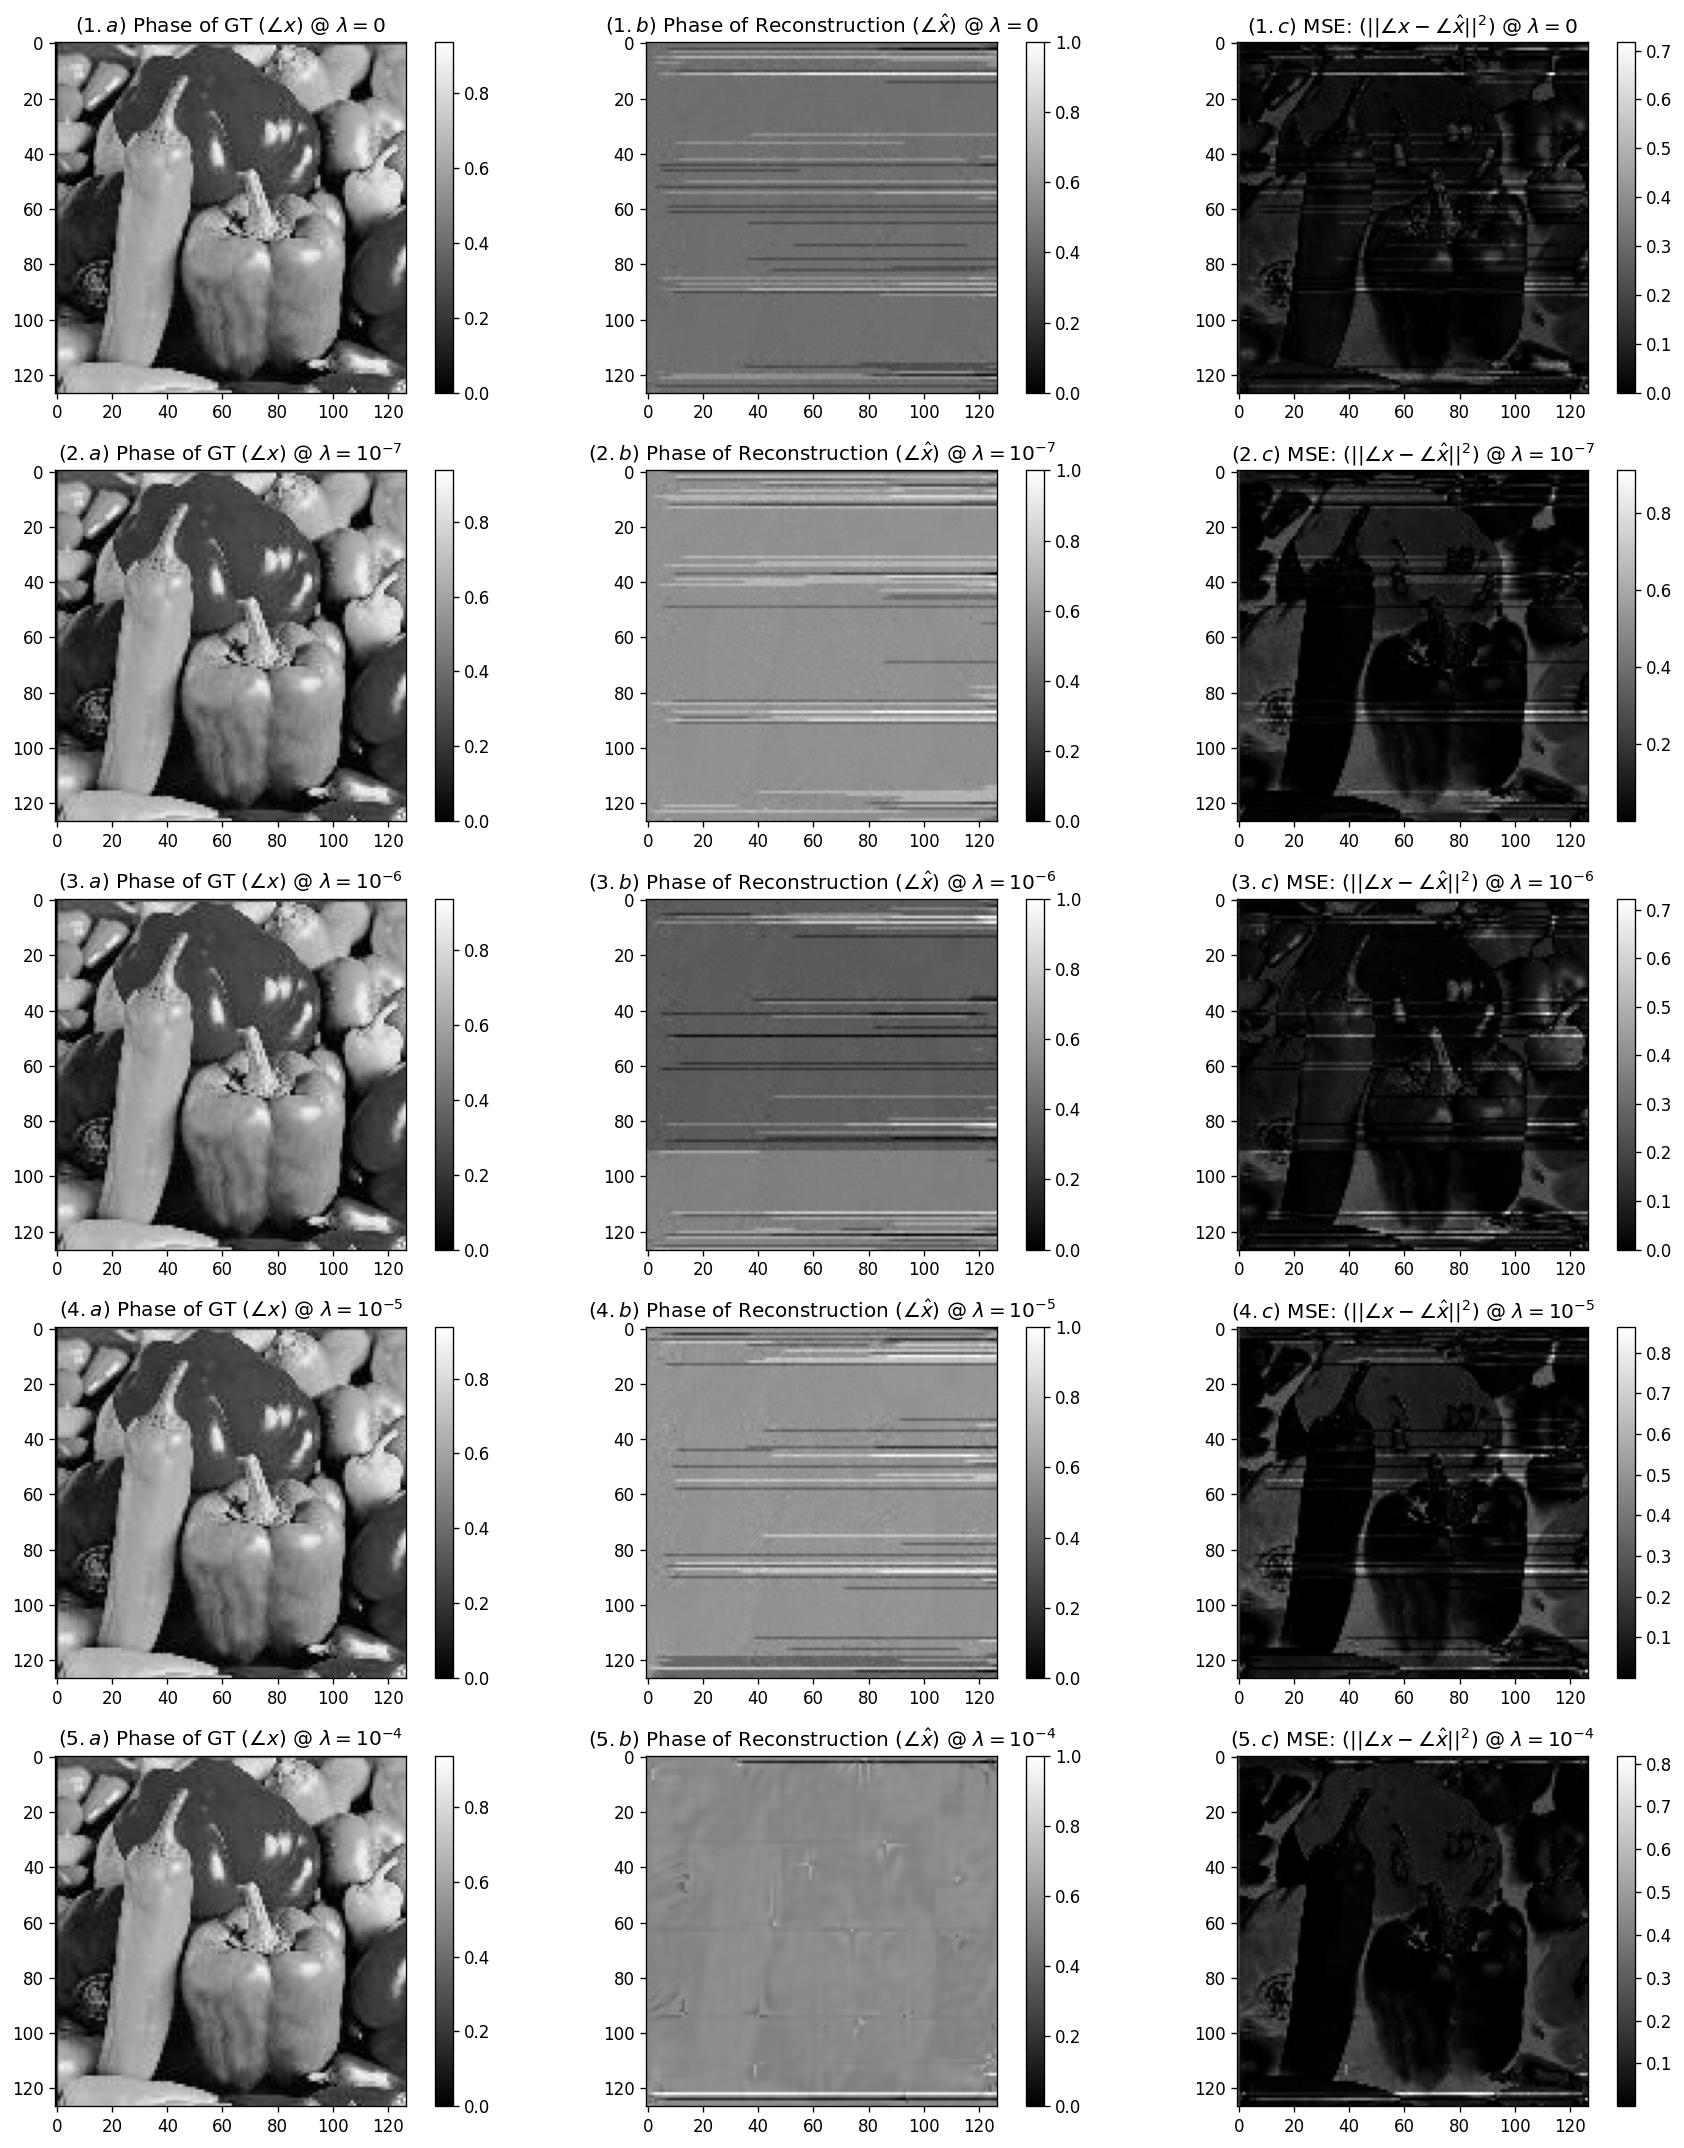

In [35]:
image = plt.imread('images/peppers_reduced.jpg')[:2**7-1, :2**7-1] / 255
plt.figure(figsize=(15, 18),dpi = 120)
plt.subplot(5, 3, 1)
plt.imshow(image,cmap='gray')
plt.title(r"$(1.a)$ Phase of GT $(\angle x)$ @ $\lambda = 0$")
plt.colorbar()
plt.subplot(5, 3, 2)
phase = torch.angle(modelinf.sols[-1][0,0,:,:].to('cpu'))
phase = unwrap_2d(phase)
phase = (phase - np.min(phase))/(np.max(phase) - np.min(phase))
plt.imshow(phase,cmap = 'gray')
plt.title(r"$(1.b)$ Phase of Reconstruction $(\angle \hat{x})$ @ $\lambda = 0$")
plt.colorbar()
plt.subplot(5, 3, 3)
plt.imshow((np.array(image)-np.array(phase))**2,cmap='gray')
plt.title(r"$(1.c)$ MSE: $(||\angle x-\angle \hat{x}||^2)$ @ $\lambda = 0$") 
plt.colorbar()


plt.subplot(5, 3, 4)
plt.imshow(image,cmap='gray')
plt.title(r"$(2.a)$ Phase of GT $(\angle x)$ @ $\lambda = 10^{-7}$")
plt.colorbar()
plt.subplot(5, 3, 5)
phase = torch.angle(model7.sols[-1][0,0,:,:].to('cpu'))
phase = unwrap_2d(phase)
phase = (phase - np.min(phase))/(np.max(phase) - np.min(phase))
plt.imshow(phase,cmap = 'gray')
plt.title(r"$(2.b)$ Phase of Reconstruction $(\angle \hat{x})$ @ $\lambda = 10^{-7}$")
plt.colorbar()
plt.subplot(5, 3, 6)
plt.imshow(np.abs(np.array(image)-np.array(phase))**2,cmap='gray')
plt.title(r"$(2.c)$ MSE: $(||\angle x-\angle \hat{x}||^2)$ @ $\lambda = 10^{-7}$") 
plt.colorbar()

plt.subplot(5, 3, 7)
plt.imshow(image,cmap='gray')
plt.title(r"$(3.a)$ Phase of GT $(\angle x)$ @ $\lambda = 10^{-6}$")
plt.colorbar()
plt.subplot(5, 3, 8)
phase = torch.angle(model6.sols[-1][0,0,:,:].to('cpu'))
phase = unwrap_2d(phase)
phase = (phase - np.min(phase))/(np.max(phase) - np.min(phase))
plt.imshow(phase,cmap = 'gray')
plt.title(r"$(3.b)$ Phase of Reconstruction $(\angle \hat{x})$ @ $\lambda = 10^{-6}$")
plt.colorbar()
plt.subplot(5, 3, 9)
plt.imshow(np.abs(np.array(image)-np.array(phase))**2,cmap='gray')
plt.title(r"$(3.c)$ MSE: $(||\angle x-\angle \hat{x}||^2)$ @ $\lambda = 10^{-6}$") 
plt.colorbar()

plt.subplot(5, 3, 10)
plt.imshow(image,cmap='gray')
plt.title(r"$(4.a)$ Phase of GT $(\angle x)$ @ $\lambda = 10^{-5}$")
plt.colorbar()
plt.subplot(5, 3, 11)
phase = torch.angle(model5.sols[-1][0,0,:,:].to('cpu'))
phase = unwrap_2d(phase)
phase = (phase - np.min(phase))/(np.max(phase) - np.min(phase))
plt.imshow(phase,cmap = 'gray')
plt.title(r"$(4.b)$ Phase of Reconstruction $(\angle \hat{x})$ @ $\lambda = 10^{-5}$")
plt.colorbar()
plt.subplot(5, 3, 12)
plt.imshow(np.abs(np.array(image)-np.array(phase))**2,cmap='gray')
plt.title(r"$(4.c)$ MSE: $(||\angle x-\angle \hat{x}||^2)$ @ $\lambda = 10^{-5}$") 
plt.colorbar()

plt.subplot(5, 3, 13)
plt.imshow(image,cmap='gray')
plt.title(r"$(5.a)$ Phase of GT $(\angle x)$ @ $\lambda = 10^{-4}$")
plt.colorbar()
plt.subplot(5, 3, 14)
phase = torch.angle(model4.sols[-1][0,0,:,:].to('cpu'))
phase = unwrap_2d(phase)
phase = (phase - np.min(phase))/(np.max(phase) - np.min(phase))
plt.imshow(phase,cmap = 'gray')
plt.title(r"$(5.b)$ Phase of Reconstruction $(\angle \hat{x})$ @ $\lambda = 10^{-4}$")
plt.colorbar()
plt.subplot(5, 3, 15)
plt.imshow(np.abs(np.array(image)-np.array(phase))**2,cmap='gray')
plt.title(r"$(5.c)$ MSE: $(||\angle x-\angle \hat{x}||^2)$ @ $\lambda = 10^{-4}$") 
plt.colorbar()
plt.tight_layout()
plt.savefig('noisy_setup_1e35.png')